# Recurrent Neural Network
순환신경망 

학습시키기 어려움

short term memory

- hidden layer가 하나 밖에 없는 구조
- 순환의 이유: 씨퀀스 데이터는 독립적이지 않다. 
- 기억을 전달하는 것. 직전단계의 기억을 돌려받아서 학습에 사용한다.
- DNN과 CNN은 레이어 간의 상태를 기억하지 않는다. 
- 은닉층의 출력이 계속 순환하면서 입력과 함께 학습에 사용
- 연속적인 데이터 처리를 위해서는 이전 단계 처리 정보가 필요

$h_{t} = tanh(W_{x}*X_{t}+W_{h}*h_{t-1}+b$

- 싱글레이어가 반복

Issues -> LSTM (Long Short Term Memory)

- 입력값이 길어지면 베니싱 현상이 나타나고 연산횟수가 많아지면 기억이 흐릿해지는 문제가 있다. 




In [1]:
import warnings
warnings.filterwarnings('ignore')

# LSTM
* Long Term Dependency Issue 해결
* Vanishing Gradient and Gradient Issue 해결



In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [3]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


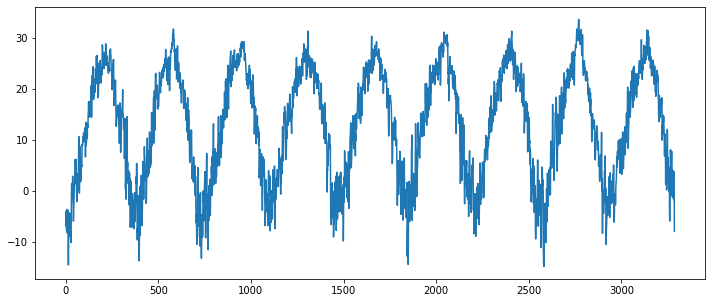

In [5]:
temp_data = temp[['avg']]

plt.figure(figsize = (12, 5))
plt.plot(temp_data)
plt.show()

In [6]:
scaler = MinMaxScaler(feature_range = (-1, 1))

temp_data = scaler.fit_transform(temp_data)

In [7]:
train=temp_data[0:2557]
test=temp_data[2557:]

In [10]:
def create_dataset(time_data,look_back=1):
    data_X,data_y=[],[]

    for  i in range(len(time_data)-look_back):
        data_X.append(time_data[i:(i+look_back),0])
        data_y.append(time_data[ i + look_back ,0])

    return np.array(data_X), np.array(data_y)

In [13]:
look_back = 180

train_X,train_y = create_dataset(train,look_back)
test_X,test_y = create_dataset(test,look_back)

train_X.shape, train_y.shape, test_X.shape,test_y.shape

((2377, 180), (2377,), (550, 180), (550,))

In [15]:
train_X = np.reshape(train_X,(train_X.shape[0],train_X.shape[1],1))
test_X = np.reshape(test_X,(test_X.shape[0],test_X.shape[1],1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

In [16]:
model = Sequential(name='LSTM')
model.add(LSTM(64,input_shape=(None,1)))
model.add(Dense(1,activation='tanh'))

In [17]:
model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss='mean_squared_error',
              optimizer = 'adam')

In [20]:
hist = model.fit(train_X,train_y,
                 epochs = 200,
                 batch_size = 16,
                 validation_data=(test_X,test_y))

Epoch 1/200
149/149 [==============================] - 9s 11ms/step - loss: 0.0229 - val_loss: 0.0144
Epoch 2/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0157 - val_loss: 0.0131
Epoch 3/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0143 - val_loss: 0.0119
Epoch 4/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0132 - val_loss: 0.0115
Epoch 5/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0124 - val_loss: 0.0108
Epoch 6/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0110 - val_loss: 0.0097
Epoch 7/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0098 - val_loss: 0.0085
Epoch 8/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0095 - val_loss: 0.0087
Epoch 9/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 10/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0086 - val_l

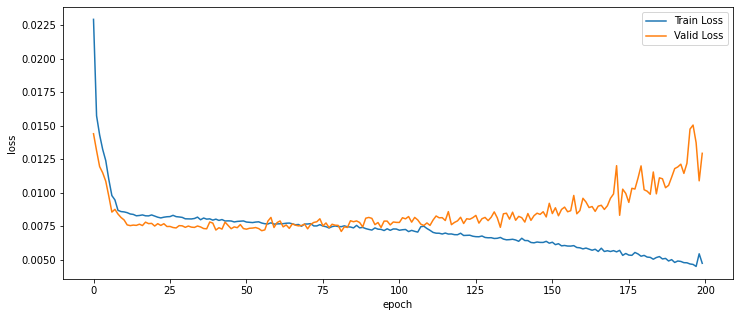

In [21]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

In [22]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  0.004216523375362158
Test Score:  0.012931630946695805


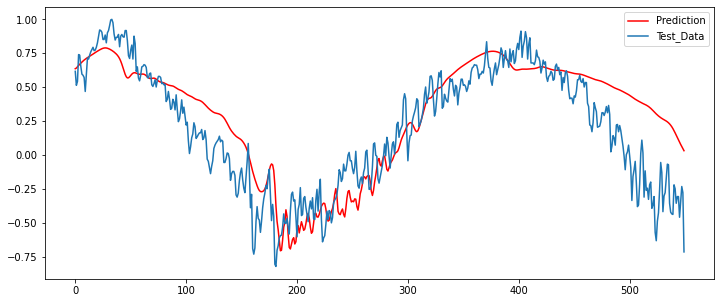

In [23]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
    
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()